In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math

In [2]:
class EncoderLayer(nn.Module):
    """
    Represents one Encoder layer of the Transformer Encoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads,
                 bias_mask=None, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(EncoderLayer, self).__init__()
        
        self.multi_head_attention = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)
        
        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='ll', padding = 'both', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)
        
    def forward(self, inputs):
        x = inputs
        
        # Layer Normalization
        x_norm = self.layer_norm_mha(x)
        
        # Multi-head attention
        y = self.multi_head_attention(x_norm, x_norm, x_norm)
        
        # Dropout and residual
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual
        y = self.dropout(x + y)
        
        return y

In [3]:
class DecoderLayer(nn.Module):
    """
    Represents one Decoder layer of the Transformer Decoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads,
                 bias_mask, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(DecoderLayer, self).__init__()
        
        self.multi_head_attention_dec = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)

        self.multi_head_attention_enc_dec = KmeansAttention(num_clusters=4, window_size=8, num_heads=num_heads, head_dim=int(hidden_size/num_heads))

        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='ll', padding = 'left', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha_dec = LayerNorm(hidden_size)
        self.layer_norm_mha_enc = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)
        
        self.num_heads = num_heads
        self.d_model = hidden_size
        
    def forward(self, inputs):
        """
        NOTE: Inputs is a tuple consisting of decoder inputs and encoder output
        """
        x, encoder_outputs = inputs
        
        # Layer Normalization before decoder self attention
        x_norm = self.layer_norm_mha_dec(x)
        
        # Masked Multi-head attention
        y = self.multi_head_attention_dec(x_norm, x_norm, x_norm)
        
        # Dropout and residual after self-attention
        x = self.dropout(x + y)

        # Layer Normalization before encoder-decoder attention
        x_norm = self.layer_norm_mha_enc(x)
        
        b, t, e, h, dh = *x_norm.shape, self.num_heads, self.d_model
        split_heads = lambda v: v.reshape(b, -1, h, int(dh/h)).transpose(1, 2).contiguous()
        x_norm, encoder_outputs = map(split_heads, (x_norm, encoder_outputs))

        # Multi-head encoder-decoder attention
        y = self.multi_head_attention_enc_dec(x_norm, encoder_outputs, encoder_outputs)
        y = y.reshape(b, t, e)
        
        # Dropout and residual after encoder-decoder attention
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual after positionwise feed forward layer
        y = self.dropout(x + y)
        
        # Return encoder outputs as well to work with nn.Sequential
        return y, encoder_outputs

In [4]:
def identity(x, *args, **kwargs):
    return x

def default(x, d):
    if x is None:
        return d if not isfunction(d) else d()
    return x

def cast_tuple(x):
    return x if isinstance(x, tuple) else (x,)

def cache_fn(f):
    cache = None
    @wraps(f)
    def cached_fn(*args, **kwargs):
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache
    return cached_fn

def to(t):
    return {'device': t.device, 'dtype': t.dtype}

def find_modules(nn_module, type):
    return [module for module in nn_module.modules() if isinstance(module, type)]

def is_empty(t):
    return t.nelement() == 0

def max_neg_value(tensor):
    return -torch.finfo(tensor.dtype).max

def batched_index_select(values, indices):
    last_dim = values.shape[-1]
    return values.gather(2, expand_dim(indices, -1, last_dim))

def merge_dims(ind_from, ind_to, tensor):
    shape = list(tensor.shape)
    arr_slice = slice(ind_from, ind_to + 1)
    shape[arr_slice] = [reduce(mul, shape[arr_slice])]
    return tensor.reshape(*shape)

def expand_dim(t, dim, k):
    t = t.unsqueeze(dim)
    expand_shape = [-1] * len(t.shape)
    expand_shape[dim] = k
    return t.expand(*expand_shape)

def scatter_mean(src, t, index, dim, eps = 1e-5):
    numer = src.scatter_add(dim, index, t)
    denom = src.scatter_add(dim, index, torch.ones_like(t))
    return numer / (denom + eps)

def split_at_index(dim, index, t):
    pre_slices = (slice(None),) * dim
    l = (*pre_slices, slice(None, index))
    r = (*pre_slices, slice(index, None))
    return t[l], t[r]

def ema(old, new, decay):
    if old is None:
        return new
    return old * decay + new * (1 - decay)

def ema_inplace(moving_avg, new, decay):
    if is_empty(moving_avg):
        moving_avg.data.copy_(new)
        return
    moving_avg.data.mul_(decay).add_(new, alpha= (1 - decay))

# helper classes

class Chunk(nn.Module):
    def __init__(self, chunks, fn, along_dim = -1):
        super().__init__()
        self.dim = along_dim
        self.chunks = chunks
        self.fn = fn

    def forward(self, x, **kwargs):
        if self.chunks <= 1:
            return self.fn(x, **kwargs)
        chunks = x.chunk(self.chunks, dim = self.dim)
        return torch.cat([self.fn(c, **kwargs) for c in chunks], dim = self.dim)

class PreNorm(nn.ModuleList):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        x = self.norm(x)
        return self.fn(x, **kwargs)

class ProjectInOut(nn.Module):
    def __init__(self, fn, dim_in, dim_out, project_out = True):
        super().__init__()
        self.fn = fn
        self.project_in = nn.Linear(dim_in, dim_out)
        self.project_out = nn.Linear(dim_out, dim_in) if project_out else identity

    def forward(self, x, **kwargs):
        x = self.project_in(x)
        x, loss = self.fn(x, **kwargs)
        x = self.project_out(x)
        return x, loss

# kmeans related function and class

def update_kmeans_on_backwards(module):
    module.kmean_modules = find_modules(module, Kmeans)
    def hook(_, grad_in, grad_out):
        for m in module.kmean_modules:
            m.update()

    return module.register_backward_hook(hook)

def similarity(x, means):
    return torch.einsum('bhld,hcd->bhlc', x, means)

def dists_and_buckets(x, means):
    dists = similarity(x, means)
    _, buckets = torch.max(dists, dim=-1)
    return dists, buckets

def batched_bincount(index, num_classes, dim=-1):
    shape = list(index.shape)
    shape[dim] = num_classes
    out = index.new_zeros(shape)
    out.scatter_add_(dim, index, torch.ones_like(index, dtype=index.dtype))
    return out

def kmeans_iter(x, means, buckets = None):
    b, h, l, d, dtype, num_clusters = *x.shape, x.dtype, means.shape[1]

    if buckets is None:
        _, buckets = dists_and_buckets(x, means)

    bins = batched_bincount(buckets, num_clusters).sum(0, keepdim=True)
    zero_mask = bins.long() == 0

    means_ = buckets.new_zeros(b, h, num_clusters, d, dtype=dtype)
    means_.scatter_add_(-2, expand_dim(buckets, -1, d), x)
    means_ = F.normalize(means_.sum(0, keepdim=True), dim=-1).type(dtype)

    means = torch.where(zero_mask.unsqueeze(-1), means, means_)
    means = means.squeeze(0)
    return means

def distribution(dists, window_size):
    _, topk_indices = dists.topk(k=window_size, dim=-2)
    indices = topk_indices.transpose(-2, -1)
    return indices.reshape(*indices.size()[:2], -1)

In [5]:
from inspect import isfunction

In [6]:
TOKEN_SELF_ATTN_VALUE = -5e4
KMEAN_INIT_ITERS = 10

In [7]:
class Kmeans(nn.Module):
    def __init__(self, num_heads, head_dim, num_clusters, ema_decay = 0.999, commitment = 1e-4):
        super().__init__()
        self.commitment = commitment
        self.ema_decay = ema_decay

        self.register_buffer('means', torch.randn(num_heads, num_clusters, head_dim))
        self.register_buffer('initted', torch.tensor(False))
        self.num_new_means = 0
        self.new_means = None

    @torch.no_grad()
    def init(self, x):
        if self.initted:
            return
        _, h, _, d, device, dtype = *x.shape, x.device, x.dtype

        num_clusters = self.means.shape[1]

        means = x.transpose(0, 1).contiguous().view(h, -1, d)
        num_samples = means.shape[1]

        if num_samples >= num_clusters:
            indices = torch.randperm(num_samples, device=device)[:num_clusters]
        else:
            indices = torch.randint(0, num_samples, (num_clusters,), device=device)

        means = means[:, indices]

        for _ in range(KMEAN_INIT_ITERS):
            means = kmeans_iter(x, means)

        self.num_new_means = 0
        self.means.data.copy_(means)
        self.initted.data.copy_(torch.tensor(True))

    @torch.no_grad()
    def update(self, new_means = None):
        new_means = default(new_means, self.new_means)
        assert new_means is not None, 'new kmeans has not been supplied'
        ema_inplace(self.means, new_means, self.ema_decay)

        del self.new_means
        self.new_means = None
        self.num_new_means = 0

    def forward(self, x, update_means = False):
        self.init(x)

        b, dtype = x.shape[0], x.dtype
        means = self.means.type(dtype)
        x = F.normalize(x, 2, dim=-1).type(dtype)

        with torch.no_grad():
            dists, buckets = dists_and_buckets(x, means)

        routed_means = batched_index_select(expand_dim(means, 0, b), buckets)
        loss = F.mse_loss(x, routed_means) * self.commitment

        if update_means:
            with torch.no_grad():
                means = kmeans_iter(x, means, buckets)
            self.new_means = ema(self.new_means, means, self.num_new_means / (self.num_new_means + 1))
            self.num_new_means += 1

        return dists, loss

In [8]:
class KmeansAttention(nn.Module):
    def __init__(self, num_clusters, window_size, num_heads, head_dim, causal = False, dropout = 0., ema_decay = 0.999, commitment = 1e-4, context_window_size = None, receives_context = False, num_mem_kv = 0, shared_qk = False):
        super().__init__()
        self.num_heads = num_heads
        self.num_clusters = num_clusters
        self.head_dim = head_dim

        self.window_size = window_size
        self.context_window_size = default(context_window_size, window_size)
        self.causal = causal

        self.shared_qk = shared_qk
        self.receives_context = receives_context
        self.kmeans = Kmeans(num_heads, head_dim, num_clusters, ema_decay, commitment)
        self.dropout = nn.Dropout(dropout)

        self.num_mem_kv = max(num_mem_kv, 1 if causal and not shared_qk else 0)
        self.mem_key = nn.Parameter(torch.randn(num_heads, num_clusters, self.num_mem_kv, head_dim))
        self.mem_value = nn.Parameter(torch.randn(num_heads, num_clusters, self.num_mem_kv, head_dim))

    def forward(self, q, k, v, query_mask = None, key_mask = None, **kwargs):
        b, h, t, d, kv_t, wsz, c_wsz, nc, device, dtype = *q.shape, k.shape[2], self.window_size, self.context_window_size, self.num_clusters, q.device, q.dtype
        is_reverse = kwargs.pop('_reverse', False)

        out = torch.zeros_like(q, dtype=dtype)

        update_kmeans = self.training and not is_reverse
        
        key_mask = default(key_mask, query_mask) if not self.receives_context else key_mask
        kv_wsz = wsz if not self.receives_context else c_wsz

        wsz = min(wsz, t)
        kv_wsz = min(kv_wsz, kv_t)

        if not self.shared_qk or self.receives_context:
            dists, aux_loss = self.kmeans(torch.cat((q, k), dim=2), update_kmeans)
            q_dists, k_dists = split_at_index(2, t, dists)
            indices = distribution(q_dists, wsz)
            kv_indices = distribution(k_dists, kv_wsz)
        else:
            dists, aux_loss = self.kmeans(q, update_kmeans)
            k = F.normalize(k, dim=-1).to(q)
            indices = distribution(dists, wsz)
            kv_indices = indices

        q = batched_index_select(q, indices)
        k = batched_index_select(k, kv_indices)
        v = batched_index_select(v, kv_indices)

        reshape_with_window = lambda x: x.reshape(b, h, nc, -1, d)
        q, k, v = map(reshape_with_window, (q, k, v))

        m_k, m_v = map(lambda x: expand_dim(x, 0, b).to(q), (self.mem_key, self.mem_value))
        k, v = map(lambda x: torch.cat(x, dim=3), ((m_k, k), (m_v, v)))

        dots = torch.einsum('bhnid,bhnjd->bhnij', q, k) * (d ** -0.5)

        mask_value = max_neg_value(dots)

        if query_mask is not None or key_mask is not None:
            query_mask = default(query_mask, lambda: torch.ones((b, t), device=device).bool())
            key_mask = default(key_mask, lambda: torch.ones((b, kv_t), device=device).bool())

            q_mask = expand_dim(query_mask, 1, h).gather(2, indices)
            kv_mask = expand_dim(key_mask, 1, h).gather(2, kv_indices)
            q_mask, kv_mask = map(lambda t: t.reshape(b, h, nc, -1), (q_mask, kv_mask))
            mask = q_mask[:, :, :, :, None] * kv_mask[:, :, :, None, :]
            mask = F.pad(mask, (self.num_mem_kv, 0), value=True)
            dots.masked_fill_(~mask, mask_value)
            del mask

        if self.causal:
            q_mask, kv_mask = map(lambda t: t.reshape(b, h, nc, -1), (indices, kv_indices))
            mask = q_mask[:, :, :, :, None] >= kv_mask[:, :, :, None, :]
            mask = F.pad(mask, (self.num_mem_kv, 0), value=True)
            dots.masked_fill_(~mask, mask_value)
            del mask            

        if self.shared_qk:
            q_mask, kv_mask = map(lambda t: t.reshape(b, h, nc, -1), (indices, kv_indices))
            mask = q_mask[:, :, :, :, None] == kv_mask[:, :, :, None, :]
            mask = F.pad(mask, (self.num_mem_kv, 0), value=False)
            dots.masked_fill_(mask, TOKEN_SELF_ATTN_VALUE)
            del mask

        dots = dots.softmax(dim=-1)
        dots = self.dropout(dots)

        bo = torch.einsum('bhcij,bhcjd->bhcid', dots, v)
        so = torch.reshape(bo, (b, h, -1, bo.shape[-1])).type(dtype)
        out = scatter_mean(out, so, indices.unsqueeze(-1).expand_as(so), -2)
        return out

In [9]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention as per https://arxiv.org/pdf/1706.03762.pdf
    Refer Figure 2
    """
    def __init__(self, input_depth, total_key_depth, total_value_depth, output_depth, 
                 num_heads, bias_mask=None, dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(MultiHeadAttention, self).__init__()
        # Checks borrowed from 
        # https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
        if total_key_depth % num_heads != 0:
            raise ValueError("Key depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_key_depth, num_heads))
        if total_value_depth % num_heads != 0:
            raise ValueError("Value depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_value_depth, num_heads))
            
        self.num_heads = num_heads
        self.query_scale = (total_key_depth//num_heads)**-0.5
        self.bias_mask = bias_mask
        
        # Key and query depth will be same
        self.query_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.key_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.value_linear = nn.Linear(input_depth, total_value_depth, bias=False)
        self.output_linear = nn.Linear(total_value_depth, output_depth, bias=False)
        
        self.dropout = nn.Dropout(dropout)
    
    def _split_heads(self, x):
        """
        Split x such to add an extra num_heads dimension
        Input:
            x: a Tensor with shape [batch_size, seq_length, depth]
        Returns:
            A Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        """
        if len(x.shape) != 3:
            raise ValueError("x must have rank 3")
        shape = x.shape
        return x.view(shape[0], shape[1], self.num_heads, shape[2]//self.num_heads).permute(0, 2, 1, 3)
    
    def _merge_heads(self, x):
        """
        Merge the extra num_heads into the last dimension
        Input:
            x: a Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        Returns:
            A Tensor with shape [batch_size, seq_length, depth]
        """
        if len(x.shape) != 4:
            raise ValueError("x must have rank 4")
        shape = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(shape[0], shape[2], shape[3]*self.num_heads)
        
    def forward(self, queries, keys, values, src_mask=None):
        
        # Do a linear for each component
        queries = self.query_linear(queries)
        keys = self.key_linear(keys)
        values = self.value_linear(values)
        
        # Split into multiple heads
        queries = self._split_heads(queries)
        keys = self._split_heads(keys)
        values = self._split_heads(values)
        
        # Scale queries
        queries *= self.query_scale
        
        # Combine queries and keys
        logits = torch.matmul(queries, keys.permute(0, 1, 3, 2))
        

        if src_mask is not None:
            logits = logits.masked_fill(src_mask, -np.inf)
            
        # Add bias to mask future values
        if self.bias_mask is not None:
            logits += self.bias_mask[:, :, :logits.shape[-2], :logits.shape[-1]].type_as(logits.data)
        
        # Convert to probabilites
        weights = nn.functional.softmax(logits, dim=-1)
        
        # Dropout
        weights = self.dropout(weights)
        
        # Combine with values to get context
        contexts = torch.matmul(weights, values)
        
        # Merge heads
        contexts = self._merge_heads(contexts)
        #contexts = torch.tanh(contexts)
        
        # Linear to get output
        outputs = self.output_linear(contexts)
        
        return outputs

In [10]:
class PositionwiseFeedForward(nn.Module):
    """
    Does a Linear + RELU + Linear on each of the timesteps
    """
    def __init__(self, input_depth, filter_size, output_depth, layer_config='ll', padding='left', dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            filter_size: Hidden size of the middle layer
            output_depth: Size last dimension of the final output
            layer_config: ll -> linear + ReLU + linear
                          cc -> conv + ReLU + conv etc.
            padding: left -> pad on the left side (to mask future data), 
                     both -> pad on both sides
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(PositionwiseFeedForward, self).__init__()
        
        layers = []
        sizes = ([(input_depth, filter_size)] + 
                 [(filter_size, filter_size)]*(len(layer_config)-2) + 
                 [(filter_size, output_depth)])

        for lc, s in zip(list(layer_config), sizes):
            if lc == 'l':
                layers.append(nn.Linear(*s))
            else:
                raise ValueError("Unknown layer type {}".format(lc))

        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs):
        x = inputs
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers):
                x = self.relu(x)
                x = self.dropout(x)

        return x


In [11]:
class LayerNorm(nn.Module):
    # Borrowed from jekbradbury
    # https://github.com/pytorch/pytorch/issues/1959
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


In [12]:
def _gen_bias_mask(max_length):
    """
    Generates bias values (-Inf) to mask future timesteps during attention
    """
    np_mask = np.triu(np.full([max_length, max_length], -np.inf), 1)
    torch_mask = torch.from_numpy(np_mask).type(torch.FloatTensor)
    
    return torch_mask.unsqueeze(0).unsqueeze(1)

In [13]:
def _gen_timing_signal(length, channels, min_timescale=1.0, max_timescale=1.0e4):
    """
    Generates a [1, length, channels] timing signal consisting of sinusoids
    Adapted from:
    https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
    """
    position = np.arange(length)
    num_timescales = channels // 2
    log_timescale_increment = ( math.log(float(max_timescale) / float(min_timescale)) / (float(num_timescales) - 1))
    inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)
    scaled_time = np.expand_dims(position, 1) * np.expand_dims(inv_timescales, 0)

    signal = np.concatenate([np.sin(scaled_time), np.cos(scaled_time)], axis=1)
    signal = np.pad(signal, [[0, 0], [0, channels % 2]], 
                    'constant', constant_values=[0.0, 0.0])
    signal =  signal.reshape([1, length, channels])

    return torch.from_numpy(signal).type(torch.FloatTensor)

In [14]:
class Encoder(nn.Module):
    """
    A Transformer Encoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False):
        """
        Parameters:
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
            use_mask: Set to True to turn on future value masking
        """
        
        super(Encoder, self).__init__()
        
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)

        self.num_layers = num_layers
        
        self.encs = nn.ModuleList(
            [
                EncoderLayer(
                    hidden_size, 
                    total_key_depth or hidden_size,
                    total_value_depth or hidden_size,
                    filter_size, 
                    num_heads, 
                    _gen_bias_mask(max_length) if use_mask else None,
                    layer_dropout, 
                    attention_dropout, 
                    relu_dropout
                )
                for _ in range(num_layers)
            ]
        )
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)

    def forward(self, inputs):

        #Add input dropout
        x = self.input_dropout(inputs)
        x += self.position_signal[:, 0, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)

        for enc in self.encs:
            x = enc(x)
        return x

In [15]:
class Decoder(nn.Module):
    """
    A Transformer Decoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(Decoder, self).__init__()
        
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)
        self.num_layers = num_layers
        
        self.decs = nn.ModuleList(
            [
                DecoderLayer(
                    hidden_size, 
                    total_key_depth or hidden_size,
                    total_value_depth or hidden_size,
                    filter_size, 
                    num_heads, 
                    _gen_bias_mask(max_length), # mandatory
                    layer_dropout, 
                    attention_dropout, 
                    relu_dropout
                )
                for _ in range(num_layers)
            ]
        )
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)
    
    def forward(self, inputs, encoder_output):
        #Add input dropout
        x = self.input_dropout(inputs)
        x += self.position_signal[:, 0, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)

        for dec in self.decs:
            x, _ = dec((x, encoder_output))
        return x


In [16]:
class Transformer(nn.Module):
    """
    A Transformer Module For BabI data. 
    Inputs should be in the shape story: [batch_size, memory_size, story_len ]
                                  query: [batch_size, 1, story_len]
    Outputs will have the shape [batch_size, ]
    """
    def __init__(self, output_size, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=71, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False):
        super(Transformer, self).__init__()

        self.transformer_enc = Encoder(hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                                filter_size, max_length=71, input_dropout=input_dropout, layer_dropout=layer_dropout, 
                                attention_dropout=attention_dropout, relu_dropout=relu_dropout, use_mask=False)
        
        self.transformer_dec = Decoder(hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                                filter_size, max_length=71, input_dropout=input_dropout, layer_dropout=layer_dropout, 
                                attention_dropout=attention_dropout, relu_dropout=relu_dropout)
        
        self.W = nn.Linear(hidden_size, output_size)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, story, trg):

        logit = self.transformer_enc(story)
        
        logit = self.transformer_dec(trg, logit)
        
        a_hat = self.W(torch.sum(logit,dim=1)/logit.size(1)) ## reduce mean

        return a_hat, self.softmax(a_hat)


In [17]:
output_size = 1
hidden_size=20
total_key_depth=20
total_value_depth=20
filter_size=64
num_layers=2
num_heads=2

In [18]:
model = Transformer(
    output_size, 
    hidden_size, 
    num_layers, 
    num_heads, 
    total_key_depth, 
    total_value_depth,
    filter_size
)

<ipython-input-13-e41c5c72579e>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)


In [19]:
story = torch.rand(5,21,20)
trg = torch.rand(5,1,20)

In [20]:
output, softmax_output = model(story, trg)
print(output.shape)
print(output)

torch.Size([5, 1])
tensor([[0.2209],
        [0.4991],
        [0.8710],
        [0.1475],
        [0.6001]], grad_fn=<AddmmBackward0>)


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [22]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)
input

,date,AOAL,AOAR,PITCH,W,MACH,AIRSPD,TEFLAPL,XIDA,T,...,OPR,OTL,OTR,VIBN1L,VIBN1R,VIBN2L,VIBN2R,FE,TMAX,FS
0,0,-10.55,-4.22,-0.53,63901.05853,0.084,56.3,5,6.855,20.50,...,24,110,110,0.03,0.05,0.05,0.05,23995.070700,24572.967483,577.896783
1,1,-9.84,-3.87,-0.53,63900.67347,0.087,58.2,5,6.325,20.50,...,26,110,110,0.03,0.05,0.07,0.05,23453.775200,24572.967483,1119.192283
2,2,-9.14,-3.34,-0.53,63900.23197,0.090,60.1,5,5.710,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22821.215600,24572.967483,1751.751883
3,3,-8.09,-3.87,-0.35,63899.73805,0.093,62.0,5,5.630,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22738.950900,24572.967483,1834.016583
4,4,-7.56,-3.87,-0.35,63899.14333,0.096,63.9,5,5.365,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22464.769900,24572.967483,2108.197583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519,11544,-2.81,-3.69,-0.70,56378.87869,0.150,56.0,30,3.950,23.75,...,43,98,98,0.09,0.10,0.10,0.05,7668.487126,18764.344514,11095.857388
11520,11545,-2.99,-3.69,-0.88,56378.72144,0.150,52.0,30,4.220,23.75,...,31,98,98,0.10,0.10,0.12,0.07,7393.237132,18764.344514,11371.107383
11521,11546,-2.81,-3.69,-0.88,56378.57427,0.150,49.0,30,4.130,23.75,...,31,98,98,0.13,0.12,0.12,0.09,7484.958267,18764.344514,11279.386247
11522,11547,-2.81,-3.69,-0.70,56378.43517,0.150,46.0,30,3.950,24.00,...,31,97,97,0.13,0.15,0.18,0.09,7652.561590,18764.344514,11111.782924


In [23]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [24]:
df_for_training=df[feature_names].astype(float)

In [25]:
df_for_training.shape

(11524, 22)

In [26]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [27]:
trainX=[]
trainY=[]

In [28]:
n_future=1
n_past=20

In [29]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [30]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [31]:
trainX0=np.zeros((trainX.shape[0],22,20))
for i in range(0,trainX.shape[0]):
    trainX0[i]=trainX[i].T
trainX1=np.zeros((trainX.shape[0],21,20))
for i in range(0,trainX.shape[0]):
    trainX1[i]=trainX0[i][0:21,:]
trainX2=np.zeros((trainX.shape[0],1,20))
for i in range(0,trainX.shape[0]):
    trainX2[i]=trainX0[i][21,:]

In [32]:
trainX1_copy,trainX2_copy,trainY_copy=trainX1.copy(),trainX2.copy(),trainY.copy()

In [33]:
def random_shuffle(data1,data2,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data1)
    np.random.seed(randnum)
    np.random.shuffle(data2)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data1,data2,label

In [34]:
data1,data2,label=random_shuffle(trainX1,trainX2,trainY)

In [35]:
# Create a DataLoader for the training data
data1 = torch.from_numpy(data1).float()
data2 = torch.from_numpy(data2).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data1, data2, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [37]:
device = torch.device("cpu")

In [47]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data1, data2, targets) in enumerate(train_loader):
        data1 = data1.to(device=device)
        data2 = data2.to(device=device)
        targets = targets.to(device=device)
        output, softmax_output = model(data1, data2)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.22042027115821838
Epoch: 1 Loss: 0.2624132037162781
Epoch: 2 Loss: 0.18362374603748322
Epoch: 3 Loss: 0.25428009033203125
Epoch: 4 Loss: 0.11154685169458389
Epoch: 5 Loss: 0.24309419095516205
Epoch: 6 Loss: 0.15219104290008545
Epoch: 7 Loss: 0.19231462478637695
Epoch: 8 Loss: 0.16316474974155426
Epoch: 9 Loss: 0.2184332013130188
Epoch: 10 Loss: 0.13324108719825745
Epoch: 11 Loss: 0.17369672656059265
Epoch: 12 Loss: 0.15025725960731506
Epoch: 13 Loss: 0.19740647077560425
Epoch: 14 Loss: 0.14059197902679443
Epoch: 15 Loss: 0.21738119423389435
Epoch: 16 Loss: 0.14508771896362305
Epoch: 17 Loss: 0.2129826843738556
Epoch: 18 Loss: 0.2582331597805023
Epoch: 19 Loss: 0.2785261869430542
Epoch: 20 Loss: 0.28812846541404724
Epoch: 21 Loss: 0.16121184825897217
Epoch: 22 Loss: 0.23961582779884338
Epoch: 23 Loss: 0.19338196516036987
Epoch: 24 Loss: 0.14876733720302582
Epoch: 25 Loss: 0.22710242867469788
Epoch: 26 Loss: 0.2660568654537201
Epoch: 27 Loss: 0.26326268911361694
Epoch: 2

Epoch: 227 Loss: 0.2422627955675125
Epoch: 228 Loss: 0.15858107805252075
Epoch: 229 Loss: 0.158754363656044
Epoch: 230 Loss: 0.21924644708633423
Epoch: 231 Loss: 0.1831042617559433
Epoch: 232 Loss: 0.2244606763124466
Epoch: 233 Loss: 0.17965075373649597
Epoch: 234 Loss: 0.1897573173046112
Epoch: 235 Loss: 0.16271492838859558
Epoch: 236 Loss: 0.17135308682918549
Epoch: 237 Loss: 0.2662947177886963
Epoch: 238 Loss: 0.17878206074237823
Epoch: 239 Loss: 0.2963968813419342
Epoch: 240 Loss: 0.24719120562076569
Epoch: 241 Loss: 0.12438100576400757
Epoch: 242 Loss: 0.10128748416900635
Epoch: 243 Loss: 0.24226218461990356
Epoch: 244 Loss: 0.23607715964317322
Epoch: 245 Loss: 0.15677443146705627
Epoch: 246 Loss: 0.2048117220401764
Epoch: 247 Loss: 0.1682211309671402
Epoch: 248 Loss: 0.13822738826274872
Epoch: 249 Loss: 0.12973898649215698
Epoch: 250 Loss: 0.26520785689353943
Epoch: 251 Loss: 0.2380724996328354
Epoch: 252 Loss: 0.1262059062719345
Epoch: 253 Loss: 0.1621612012386322
Epoch: 254 Los

Epoch: 451 Loss: 0.1495569497346878
Epoch: 452 Loss: 0.19096577167510986
Epoch: 453 Loss: 0.22369368374347687
Epoch: 454 Loss: 0.13472773134708405
Epoch: 455 Loss: 0.1687929630279541
Epoch: 456 Loss: 0.15937714278697968
Epoch: 457 Loss: 0.13384471833705902
Epoch: 458 Loss: 0.1782965511083603
Epoch: 459 Loss: 0.19705162942409515
Epoch: 460 Loss: 0.12803994119167328
Epoch: 461 Loss: 0.1348172426223755
Epoch: 462 Loss: 0.15094874799251556
Epoch: 463 Loss: 0.17942266166210175
Epoch: 464 Loss: 0.16364136338233948
Epoch: 465 Loss: 0.13749068975448608
Epoch: 466 Loss: 0.1648690104484558
Epoch: 467 Loss: 0.11132753640413284
Epoch: 468 Loss: 0.24971066415309906
Epoch: 469 Loss: 0.2205752432346344
Epoch: 470 Loss: 0.13320773839950562
Epoch: 471 Loss: 0.24496203660964966
Epoch: 472 Loss: 0.19926680624485016
Epoch: 473 Loss: 0.18535958230495453
Epoch: 474 Loss: 0.19691333174705505
Epoch: 475 Loss: 0.17051586508750916
Epoch: 476 Loss: 0.1518092006444931
Epoch: 477 Loss: 0.18783405423164368
Epoch: 4

Epoch: 675 Loss: 0.16407349705696106
Epoch: 676 Loss: 0.13793624937534332
Epoch: 677 Loss: 0.2039114385843277
Epoch: 678 Loss: 0.11713222414255142
Epoch: 679 Loss: 0.1472112238407135
Epoch: 680 Loss: 0.17434155941009521
Epoch: 681 Loss: 0.19641564786434174
Epoch: 682 Loss: 0.14618593454360962
Epoch: 683 Loss: 0.18774740397930145
Epoch: 684 Loss: 0.2675379812717438
Epoch: 685 Loss: 0.13777104020118713
Epoch: 686 Loss: 0.1296144723892212
Epoch: 687 Loss: 0.29169028997421265
Epoch: 688 Loss: 0.13359954953193665
Epoch: 689 Loss: 0.15403185784816742
Epoch: 690 Loss: 0.14970184862613678
Epoch: 691 Loss: 0.17799721658229828
Epoch: 692 Loss: 0.14656241238117218
Epoch: 693 Loss: 0.12496453523635864
Epoch: 694 Loss: 0.13366292417049408
Epoch: 695 Loss: 0.18346406519412994
Epoch: 696 Loss: 0.15649458765983582
Epoch: 697 Loss: 0.14592261612415314
Epoch: 698 Loss: 0.15037356317043304
Epoch: 699 Loss: 0.17596356570720673
Epoch: 700 Loss: 0.17608314752578735
Epoch: 701 Loss: 0.1040034070611
Epoch: 70

Epoch: 899 Loss: 0.18669696152210236
Epoch: 900 Loss: 0.2368757128715515
Epoch: 901 Loss: 0.17558982968330383
Epoch: 902 Loss: 0.2816847562789917
Epoch: 903 Loss: 0.1525866985321045
Epoch: 904 Loss: 0.12152296304702759
Epoch: 905 Loss: 0.13317479193210602
Epoch: 906 Loss: 0.2549747824668884
Epoch: 907 Loss: 0.14229683578014374
Epoch: 908 Loss: 0.2954980134963989
Epoch: 909 Loss: 0.14861731231212616
Epoch: 910 Loss: 0.1170899048447609
Epoch: 911 Loss: 0.148661807179451
Epoch: 912 Loss: 0.15720559656620026
Epoch: 913 Loss: 0.24501284956932068
Epoch: 914 Loss: 0.0961129292845726
Epoch: 915 Loss: 0.2148323655128479
Epoch: 916 Loss: 0.13946595788002014
Epoch: 917 Loss: 0.14232735335826874
Epoch: 918 Loss: 0.16970910131931305
Epoch: 919 Loss: 0.13279575109481812
Epoch: 920 Loss: 0.15010815858840942
Epoch: 921 Loss: 0.11206888407468796
Epoch: 922 Loss: 0.19550369679927826
Epoch: 923 Loss: 0.13854172825813293
Epoch: 924 Loss: 0.16253365576267242
Epoch: 925 Loss: 0.2100856751203537
Epoch: 926 L

In [48]:
test_data1 = torch.from_numpy(trainX1_copy).float()
test_data2 = torch.from_numpy(trainX2_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data1, test_data2, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [49]:
predictions=[]
for batch_idx, (data1, data2, targets) in enumerate(test_loader):
    data1 = data1.to(device=device)
    data2 = data2.to(device=device)
    output, softmax_output = model(data1,data2)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [50]:
predictions = np.array(predictions)

In [51]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [52]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

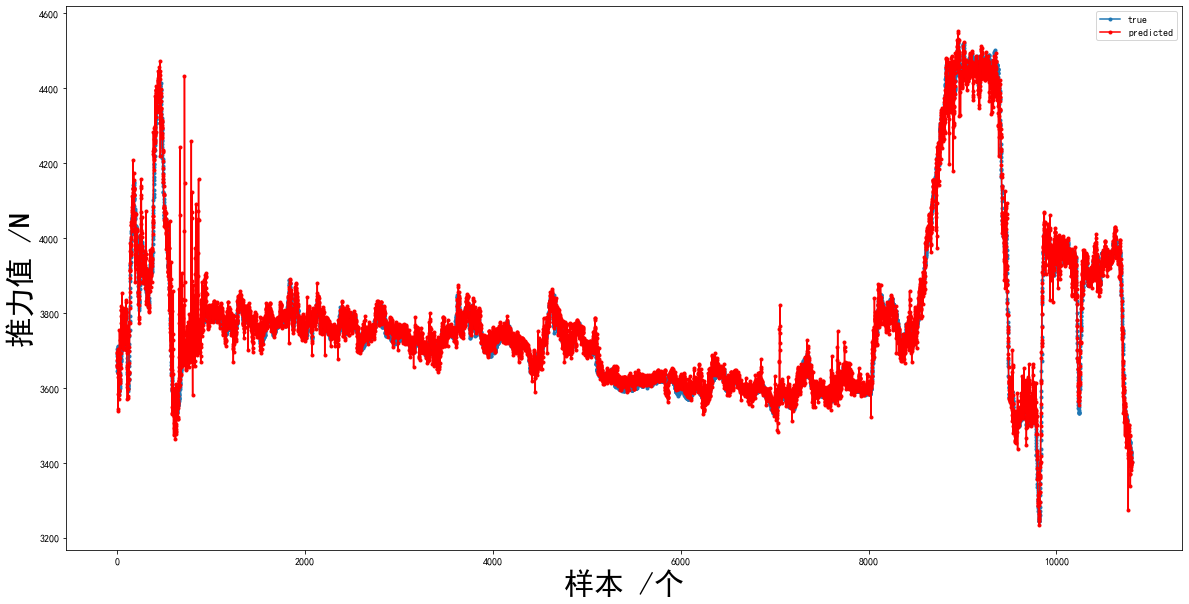

In [53]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();